# Create Project

In [1]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
#load the data

filename='Data/sales_predictions - sales_predictions.csv'
df = pd.read_csv(filename)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
#There are 12 rows and 12 columns
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Functions

In [4]:
#create function for model evaluation
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    

In [5]:
# plot coefficients functions
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    fig= ax.get_figure()
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')

#Notes for code
#sns_plot = sns.pairplot(df, hue='species', size=2.5)
#fig = sns_plot.get_figure()
#fig.savefig("output.png")
#sns.plt.show()
    
    
#sns.plt.show()
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

## Data Cleaning

In [6]:
#check for duplicates
df.duplicated().sum()


0

In [7]:
#identify missing data
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
##display rows with na values
df[df.isna().any(axis=1)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.20,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.20,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
...,...,...,...,...,...,...,...,...,...,...,...,...
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8508,FDW31,11.35,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.10,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.00,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [9]:
# there is missing data in "Item_weight" and will drop these rows
df.dropna(inplace = True)

In [10]:
#check the syntax and spelling errors
df['Item_Type'].value_counts()

Fruits and Vegetables    670
Snack Foods              656
Household                498
Frozen Foods             477
Dairy                    380
Canned                   361
Baking Goods             351
Health and Hygiene       277
Soft Drinks              241
Meat                     221
Breads                   132
Hard Drinks              117
Others                    91
Starchy Foods             87
Breakfast                 58
Seafood                   33
Name: Item_Type, dtype: int64

In [11]:
#check the fat content column
df['Item_Fat_Content'].value_counts()

Low Fat    2774
Regular    1575
LF          177
reg          71
low fat      53
Name: Item_Fat_Content, dtype: int64

In [12]:
# fix the inconsistencies  in the "item_Fat_Content"
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    3004
Regular    1646
Name: Item_Fat_Content, dtype: int64

# Preprocessing

In [13]:
#Set target
target = 'Item_Outlet_Sales'
X = df.drop(columns = target)
y = df[target]

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
3527,FDQ36,7.855,Regular,0.000000,Baking Goods,38.3848,OUT046,1997,Small,Tier 1,Supermarket Type1
7331,FDT31,19.750,Low Fat,0.012499,Fruits and Vegetables,188.0872,OUT018,2009,Medium,Tier 3,Supermarket Type2
4003,DRO47,10.195,Low Fat,0.000000,Hard Drinks,114.0860,OUT046,1997,Small,Tier 1,Supermarket Type1
2737,FDA33,6.480,Low Fat,0.033900,Snack Foods,146.9076,OUT046,1997,Small,Tier 1,Supermarket Type1
3553,FDW47,15.000,Low Fat,0.046375,Breads,122.8414,OUT046,1997,Small,Tier 1,Supermarket Type1


In [14]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002254292C2B0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002254292C280>)],
                  verbose_feature_names_out=False)

In [15]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
647,5.655,0.175352,147.4102,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5643,18.850,0.141615,169.0132,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3640,13.500,0.000000,84.5540,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


# Linear Regression

In [16]:
# instantiate the model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.70	RMSE= 824.30
Test Data:	R^2= -149221048598431520.00	RMSE= 572044856540.76


In [17]:
#visualize coefficients (manually)
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()

Item_Weight                 -4.069628e+11
Item_Visibility              4.891870e+01
Item_MRP                     5.175781e+00
Outlet_Establishment_Year    2.599630e+12
Item_Identifier_DRA12       -4.489968e+11
Name: Coefficients, dtype: float64

In [18]:
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

intercept                       -5.175733e+15
Item_Fat_Content_Regular        -1.837370e+13
Outlet_Identifier_OUT035        -1.745811e+13
Item_Fat_Content_Low Fat        -1.743115e+13
Outlet_Type_Supermarket Type2   -1.439307e+13
Outlet_Size_Medium              -8.098461e+12
Outlet_Identifier_OUT018        -4.663881e+12
Outlet_Size_Small               -4.246847e+12
Item_Identifier_FDT48           -4.138172e+12
Item_Identifier_NCA05            4.159624e+12
Item_Identifier_FDP59            4.180844e+12
Item_Identifier_FDI09            4.203640e+12
Outlet_Type_Supermarket Type1    6.607787e+12
Outlet_Identifier_OUT013         1.123134e+13
Outlet_Size_High                 1.219732e+13
Name: Coefficients, dtype: float64

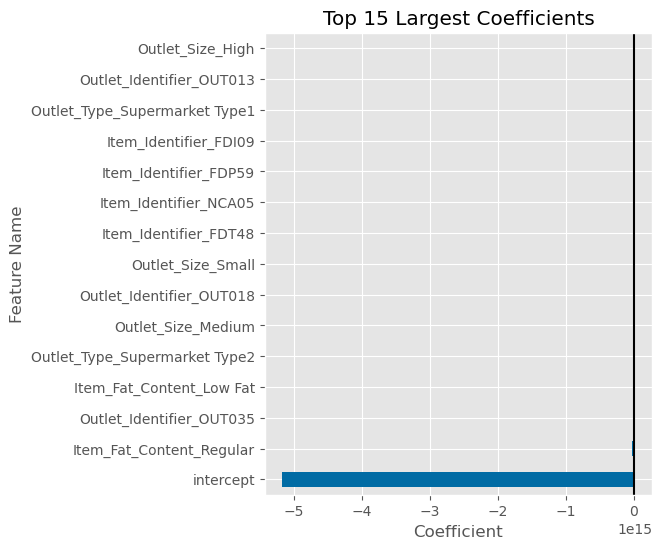

In [19]:
## sort features and keep top_n and set title
ax = coeffs_plot.sort_values().plot(kind='barh',figsize=(5,6))
ax.axvline(0,color='k');
ax.set(title = f"Top {top_n} Largest Coefficients",ylabel="Feature Name",
      xlabel='Coefficient');

## Plot coefficients with function

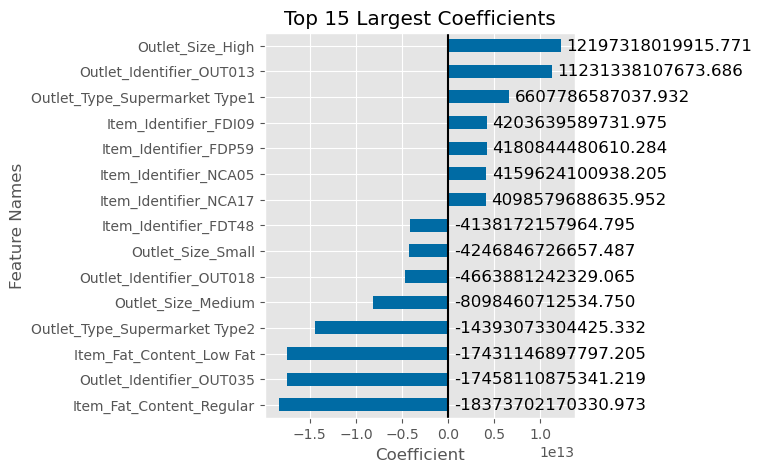

In [20]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);


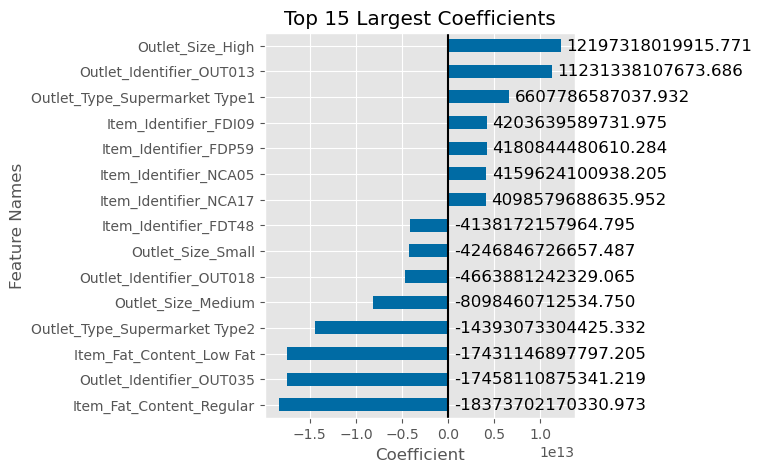

In [21]:
lr_plot = plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
fig.savefig('Images/Top 15 with Linear Regression')


### try dropping outlet  using function

### Three most impactful coefficients:
- Outlet size: the size of the outlet affect grocery sales
- Outlet identifier- this is a not useful index
- Outlet type: similar to size but  differences between a grocery store and an outlet

# Linear Regression without Outlet Identifier

In [22]:
## Get a list of all of the outlet identifier columns
outid_feats = [c for c in X_train_df.columns if c.startswith('Outlet_Identifier')]
len(outid_feats)

5

In [23]:
# ### Train Test Split
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = ["Outlet_Identifier", "Item_Identifier"]

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [24]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=feature_names,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=feature_names,
                         index=X_test.index)

In [25]:
lin_reg2= LinearRegression(fit_intercept=False)
lin_reg2.fit(X_train_df,y_train)
evaluate_regression(lin_reg2, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.47	RMSE= 1091.18
Test Data:	R^2= 0.47	RMSE= 1080.82


In [26]:
#visualize coefficients (manually)
coeffs2 = pd.Series(lin_reg2.coef_, index=feature_names,
                        name='Coefficients')
coeffs2.loc['intercept'] = lin_reg.intercept_
coeffs2.head()

Item_Weight                   -4.040570
Item_Visibility             -717.314018
Item_MRP                      16.361021
Outlet_Establishment_Year      0.015541
Item_Fat_Content_Low Fat     -11.382924
Name: Coefficients, dtype: float64

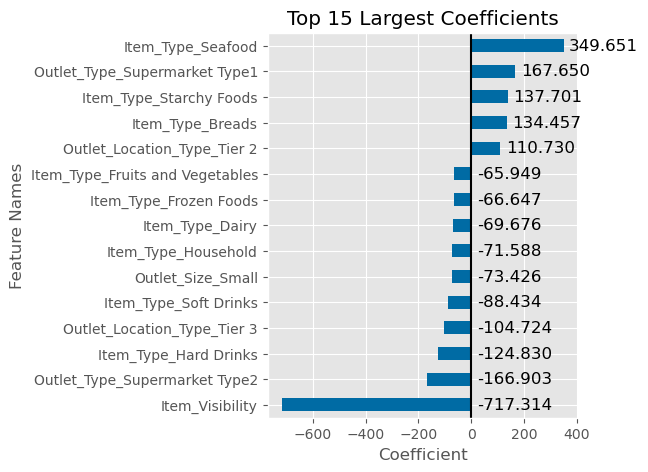

In [27]:
lr_plot = plot_coeffs(coeffs2,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
fig.savefig('Images/Top 15 with Linear Regression2')

# Random Forest Model

In [28]:
# instantiate the model, fit and evaluate
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.92	RMSE= 436.52
Test Data:	R^2= 0.38	RMSE= 1163.80


In [29]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                        0.098603
Item_Visibility                    0.124158
Item_MRP                           0.597612
Outlet_Establishment_Year          0.021478
Item_Fat_Content_Low Fat           0.006538
Item_Fat_Content_Regular           0.006880
Item_Type_Baking Goods             0.007166
Item_Type_Breads                   0.004509
Item_Type_Breakfast                0.003261
Item_Type_Canned                   0.006757
Item_Type_Dairy                    0.006844
Item_Type_Frozen Foods             0.007262
Item_Type_Fruits and Vegetables    0.009990
Item_Type_Hard Drinks              0.002930
Item_Type_Health and Hygiene       0.005686
Item_Type_Household                0.008257
Item_Type_Meat                     0.005339
Item_Type_Others                   0.001752
Item_Type_Seafood                  0.001846
Item_Type_Snack Foods              0.012876
Item_Type_Soft Drinks              0.005180
Item_Type_Starchy Foods            0.003454
Outlet_Size_High                

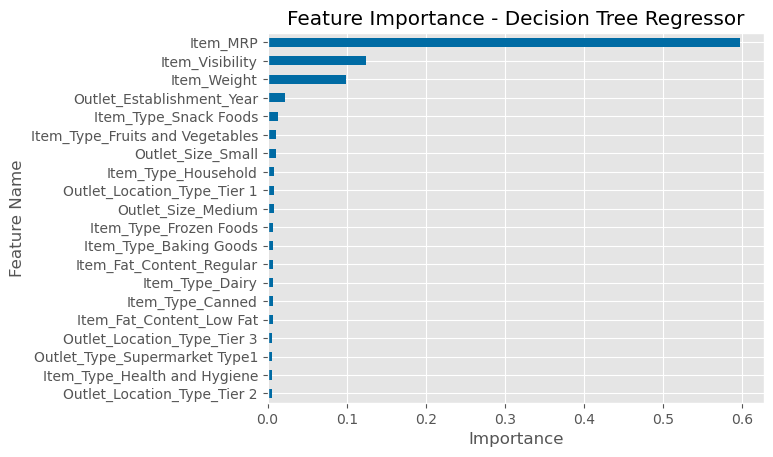

In [30]:
# Create plot
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');

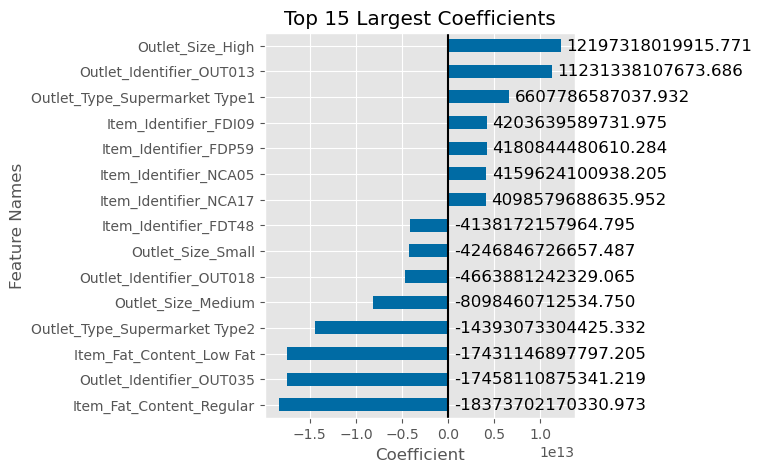

In [37]:
#save image
rf_plot = plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig=rf_plot.get_figure()
fig.savefig('Images/Top 15 with Random Forest')

### Five most important features
- Outlet Size: Bigger outlets sell more
- Outlet Identifier: Needs to be erased
- Outlet Type: Supermarkets sell more
- Item Identifier: Needs to be taken out
- Item Identifier


In [31]:
# Save figure

# Joblib

In [32]:
# look at the head
X_train.head()


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
3527,7.855,Regular,0.000000,Baking Goods,38.3848,1997,Small,Tier 1,Supermarket Type1
7331,19.750,Low Fat,0.012499,Fruits and Vegetables,188.0872,2009,Medium,Tier 3,Supermarket Type2
4003,10.195,Low Fat,0.000000,Hard Drinks,114.0860,1997,Small,Tier 1,Supermarket Type1
2737,6.480,Low Fat,0.033900,Snack Foods,146.9076,1997,Small,Tier 1,Supermarket Type1
3553,15.000,Low Fat,0.046375,Breads,122.8414,1997,Small,Tier 1,Supermarket Type1


In [34]:
# evaluate linear regression
evaluate_regression(lin_reg2,X_train_df,y_train, X_test_df, y_test)

Training Data:	R^2= 0.47	RMSE= 1091.18
Test Data:	R^2= 0.47	RMSE= 1080.82


In [35]:
#evaluate random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Training Data:	R^2= 0.92	RMSE= 436.52
Test Data:	R^2= 0.38	RMSE= 1163.80


In [36]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }
joblib.dump(export, 'best-models2.joblib')



['best-models.joblib']